In [1]:
import numpy as np
import scipy.io
import matlab.engine
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path

#### Load matlab data

In [8]:
feats = scipy.io.loadmat('output/featsCleaned.mat')
labels = scipy.io.loadmat('output/labelsCleaned.mat')

In [9]:
feats = feats['featC'].T
labels = labels['labelC'].T

In [11]:
feats.shape, labels.shape

((45695, 48), (45695, 3))

#### Explanation of shape:

This example uses the magnitude of each multipath component in the CIR as training data. Therefore, the generated CIRs are real-valued. The example stores the CIRs in a four-dimensional array of size N
s
-by-N
tx-rx
-by-N
AP
-by-N
r
.

N
s
 is the number of time-domain samples in the CIR.

N
tx-rx
 is the total number of transmit-receive antenna pairs.

N
AP
 is the number of APs.

N
r
 is the number of channel realizations for all SNR points.

https://www.mathworks.com/help/wlan/ug/three-dimensional-indoor-positioning-with-802-11az-fingerprinting-and-deep-learning.html

#### Problem: Labels shape should have at least one dimension that matches the number of time samples

Going on the assumption that labels shape will be (time samples, num aps, 3). 3 for 3 dimensions for positioning.

In [17]:
# TEMPORARY UNTIL WE FIX THE LABELS
# labels = np.random.random((feats.shape[0], 1))
# might need to scale up the sample in case there aren't enough features

In [12]:
X = torch.Tensor(feats)
Y = torch.Tensor(labels)

dataset = TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Define model

In [13]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear = nn.Linear(50, 1) # not 50, need to modify this
    
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.pool1(out)
        out = F.relu(self.conv2(out))
        out = self.pool2(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
        
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(48, 20),
            nn.ReLU(),
            # nn.BatchNorm1d(50),
            
            # nn.Linear(50, 20),
            # nn.ReLU(),
            # nn.BatchNorm1d(20),

            # nn.Linear(20, 10),
            # nn.ReLU(),
            # nn.BatchNorm1d(10),

            nn.Linear(20, 3) # x,y,z outputs
        )
    def forward(self, x):
        return self.seq(x)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleNN().to(device)

In [15]:
model

SimpleNN(
  (seq): Sequential(
    (0): Linear(in_features=48, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=3, bias=True)
  )
)

In [16]:
# crit = nn.MSELoss()
crit = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#### Training/Evaluating NN

In [17]:
num_epochs = 100
loss_tracker = np.zeros((num_epochs, 2))

for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0

    
    model = model.train()
    
    for batch_idx, (ft, lbl) in enumerate(train_loader):
        ft, lbl = ft.to(device), lbl.to(device)
        optimizer.zero_grad()
        output = model(ft)
        loss = crit(output, lbl)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    loss_tracker[epoch, 0] = train_loss
        
        
    model = model.eval()
    
    with torch.no_grad():
        for batch_idx, (ft, lbl) in enumerate(test_loader):
            ft, lbl = ft.to(device), lbl.to(device)
            output = model(ft)
            loss = crit(output, lbl)
            test_loss += loss.item()
    loss_tracker[epoch, 1] = test_loss
            
    print('Epoch {} | Training loss = {} | Test loss = {}'.format(epoch, train_loss, test_loss))

Epoch 0 | Training loss = 1290.6786665320396 | Test loss = 307.8357712626457
Epoch 1 | Training loss = 1229.9668036699295 | Test loss = 305.54256588220596
Epoch 2 | Training loss = 1220.748611330986 | Test loss = 304.0248764157295
Epoch 3 | Training loss = 1218.8964341282845 | Test loss = 303.79519724845886
Epoch 4 | Training loss = 1217.8936405181885 | Test loss = 303.48511415719986
Epoch 5 | Training loss = 1217.897456228733 | Test loss = 303.47495740652084
Epoch 6 | Training loss = 1217.3360913991928 | Test loss = 303.7830801606178
Epoch 7 | Training loss = 1217.7523266077042 | Test loss = 303.1174183487892
Epoch 8 | Training loss = 1216.3246551156044 | Test loss = 303.9525789618492
Epoch 9 | Training loss = 1216.3725197315216 | Test loss = 303.187269449234
Epoch 10 | Training loss = 1216.134094953537 | Test loss = 304.1640120148659
Epoch 11 | Training loss = 1215.453907072544 | Test loss = 302.89801889657974
Epoch 12 | Training loss = 1215.5631046295166 | Test loss = 303.6339381337

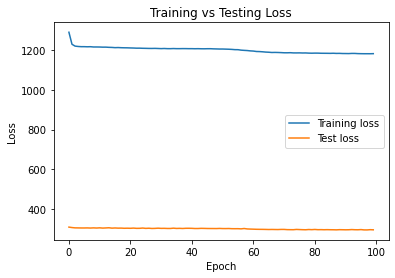

In [18]:
plt.figure()
plt.plot(loss_tracker)
plt.title('Training vs Testing Loss')
plt.legend(['Training loss', 'Test loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [19]:
# save model
model_dir = Path('./models')
model_dir.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), model_dir / '6gcnn.pth')